In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
industry = pd.read_csv("industry.csv")
industry = industry.T
industry.index = industry.index.str.lstrip()
industry.index = industry.index.str.rstrip()
industry = industry.T

In [3]:
busi_dates = pd.Series(get_trading_dates("20230504","20230519"))

In [4]:
components = index_components('000300.XSHG')

In [5]:
hs300 = get_price_change_rate(components, start_date=20230504, end_date=20230519, expect_df=True).unstack().to_frame("price_change_rate")

In [6]:
hs300 = hs300.reset_index()

In [7]:
industry = industry.sort_values(by = "order_book_id")
industry = industry.reset_index(drop = True)
industry = industry.dropna()
industry.index = industry["order_book_id"].str.replace(" ","")
industry = industry.drop("order_book_id", axis = 0)
industry = industry.drop("order_book_id", axis = 1)
keep_rows = list(hs300["order_book_id"])
keep_rows = [*set(keep_rows)]
industry = industry.T
industry = industry[industry.columns.intersection(keep_rows)]
industry = industry.T

In [8]:
hs300 = hs300.merge(industry,on = ["order_book_id"])

In [9]:
hs300.rename(columns = {'ind_number_2021':'ind'}, inplace = True)
hs300.rename(columns = {'date':'busi_date'}, inplace = True)

In [10]:
hs300["ind"] = hs300["ind"].str.replace(" ","")
hs300["ind"] = hs300["ind"].str.lstrip("ind")
hs300["ind"] = hs300["ind"].str.zfill(2)
hs300["ind"] = "ind"+ hs300["ind"]

In [11]:
max_dates = busi_dates.to_frame("dates")
max_dates["dates"] = pd.to_datetime(max_dates["dates"])
max_dates = max_dates.groupby([max_dates.dates.dt.year, max_dates.dates.dt.month]).max().values
max_dates = pd.DataFrame(max_dates)

In [12]:
max_dates.rename(columns = {0:'dates'}, inplace = True)

In [13]:
dates = []
for values in max_dates["dates"]:
    temp = index_weights('000300.XSHG', values).rename(values)
    dates.append(temp)
weights = pd.concat(dates, axis="columns").T

In [14]:
weights = weights.reindex(busi_dates)
weights = weights.fillna(method = "bfill")
weights = weights.stack().to_frame("weights")
weights.index.names = ["busi_date","order_book_id"]

In [15]:
weights = weights.sort_index()
weights = weights.reset_index()
weights = weights.sort_values(by=["order_book_id","busi_date"])
weights = weights.reset_index(drop = True)

In [16]:
weights["busi_date"] = pd.to_datetime(weights["busi_date"])
weights = weights.iloc[:,[1,0,2]]

In [17]:
hs300 = hs300.merge(weights,on = ["order_book_id","busi_date"])

In [18]:
hs300["yield"] = hs300["price_change_rate"]*hs300["weights"]

In [19]:
hs300["total_yield"] = hs300["yield"]/hs300["weights"]
hs300.rename(columns = {'ind':'industry'}, inplace = True)

In [20]:
account = pd.read_csv("data.csv")
div = pd.read_csv("data20230523.csv")

In [21]:
account["busi_date"] = pd.to_datetime(account["busi_date"])
div["busi_date"] = pd.to_datetime(div["busi_date"])
div = div.drop("ttl_asset_adj", axis=1)

In [22]:
account = account.groupby(["busi_date","industry","order_book_id","hs300"])["market","stkcode","daily_profit","hs300_iweight"].sum()

In [23]:
account = account.reset_index()

In [24]:
account["industry"] = account["industry"].str.lstrip("ind")
account["industry"] = account["industry"].str.zfill(2)
account["industry"] = "ind"+ account["industry"]

In [25]:
account = account.drop("hs300", axis = 1)

In [26]:
account = account.merge(div, on="busi_date")

In [27]:
account["yield"] = account["daily_profit"]/account["prev_ttl_asset"]

In [28]:
account["total_yield"] = account["yield"]/account["hs300_iweight"]

In [29]:
results = hs300.groupby(["busi_date","industry"])["weights","total_yield"].sum()

In [30]:
results2 = account.groupby(["busi_date","industry"])["hs300_iweight","total_yield"].sum()

In [31]:
results.rename(columns = {'weights':'benchmark_weight'}, inplace = True)
results.rename(columns = {'total_yield':'benchmark_yield'}, inplace = True)
results2.rename(columns = {'hs300_iweight':'account_weight'}, inplace = True)
results2.rename(columns = {'total_yield':'account_yield'}, inplace = True)

In [32]:
results = results.merge(results2, on = ["industry","busi_date"])

In [33]:
results = results.groupby(["busi_date","industry"]).sum()

In [34]:
results

benchmark_weight  benchmark_yield  account_weight  \
busi_date  industry                                                      
2023-05-04 ind01              0.06940         0.116776         0.06940   
           ind02              0.03163         0.117872         0.03163   
           ind03              0.03274        -0.154704         0.03274   
           ind04              0.02863         0.280529         0.02863   
           ind05              0.02468        -0.011598         0.02420   
...                               ...              ...             ...   
2023-05-19 ind26              0.05172        -0.054818         0.04629   
           ind27              0.01236        -0.017974         0.01316   
           ind28              0.09779        -0.376352         0.09882   
           ind29              0.01413        -0.062521         0.01386   
           ind31              0.00427        -0.015569         0.00068   

                     account_yield  
busi_date  industry                 
2023-05-04 ind01          0.047733  
           ind02         -0.013961  
           ind03          0.003441  
           ind04          0.208412  
           ind05         -0.028123  
...                            ...  
2023-05-19 ind26         -0.046555  
           ind27          0.020678  
           ind28         -0.254665  
           ind29         -0.065393  
           ind31         -0.009559  

[336 rows x 4 columns]

In [35]:
bhb_model = pd.DataFrame(index = results.index)

In [36]:
bhb_model["R^P"] = results["account_weight"]*results["account_yield"]
bhb_model["R^B"] = results["benchmark_weight"]*results["benchmark_yield"]
bhb_model["AR"] = (results["account_weight"]-results["benchmark_weight"])*results["benchmark_yield"]
bhb_model["SR"] = (results["account_yield"]-results["benchmark_yield"])*results["benchmark_weight"]
bhb_model["IR"] = (results["account_weight"]-results["benchmark_weight"])*(results["account_yield"]-results["benchmark_yield"])

In [37]:
bhb_model

R^P       R^B        AR        SR            IR
busi_date  industry                                                      
2023-05-04 ind01     0.003313  0.008104  0.000000 -0.004792 -0.000000e+00
           ind02    -0.000442  0.003728  0.000000 -0.004170 -0.000000e+00
           ind03     0.000113 -0.005065 -0.000000  0.005178  0.000000e+00
           ind04     0.005967  0.008032  0.000000 -0.002065 -0.000000e+00
           ind05    -0.000681 -0.000286  0.000006 -0.000408  7.932366e-06
...                       ...       ...       ...       ...           ...
2023-05-19 ind26    -0.002155 -0.002835  0.000298  0.000427 -4.486820e-05
           ind27     0.000272 -0.000222 -0.000014  0.000478  3.092170e-05
           ind28    -0.025166 -0.036803 -0.000388  0.011900  1.253372e-04
           ind29    -0.000906 -0.000883  0.000017 -0.000041  7.754549e-07
           ind31    -0.000007 -0.000066  0.000056  0.000026 -2.157644e-05

[336 rows x 5 columns]

In [38]:
bhb_industry = bhb_model.groupby("industry")["AR","SR","IR"].sum()

In [39]:
bhb_industry["R^A"] = bhb_industry["AR"]+bhb_industry["SR"]+bhb_industry["IR"]

In [40]:
bhb_industry

,AR,SR,IR,R^A
industry,,,,
ind01,2.472590e-04,-0.017109,2.158072e-05,-1.684013e-02
ind02,-2.860386e-04,-0.004954,-7.932262e-05,-5.319304e-03
ind03,1.209660e-03,0.014836,-9.785899e-04,1.506700e-02
ind04,-2.080718e-04,-0.007121,1.534805e-04,-7.175247e-03
ind05,7.213076e-04,0.004695,-5.205406e-04,4.896159e-03
ind06,-5.475586e-07,-0.000868,1.110386e-05,-8.578919e-04
ind07,4.903892e-04,0.006498,-1.294231e-04,6.858590e-03
ind09,2.520324e-04,0.003551,-1.485445e-04,3.654312e-03
ind10,-8.604225e-05,-0.000099,4.442168e-05,-1.408951e-04


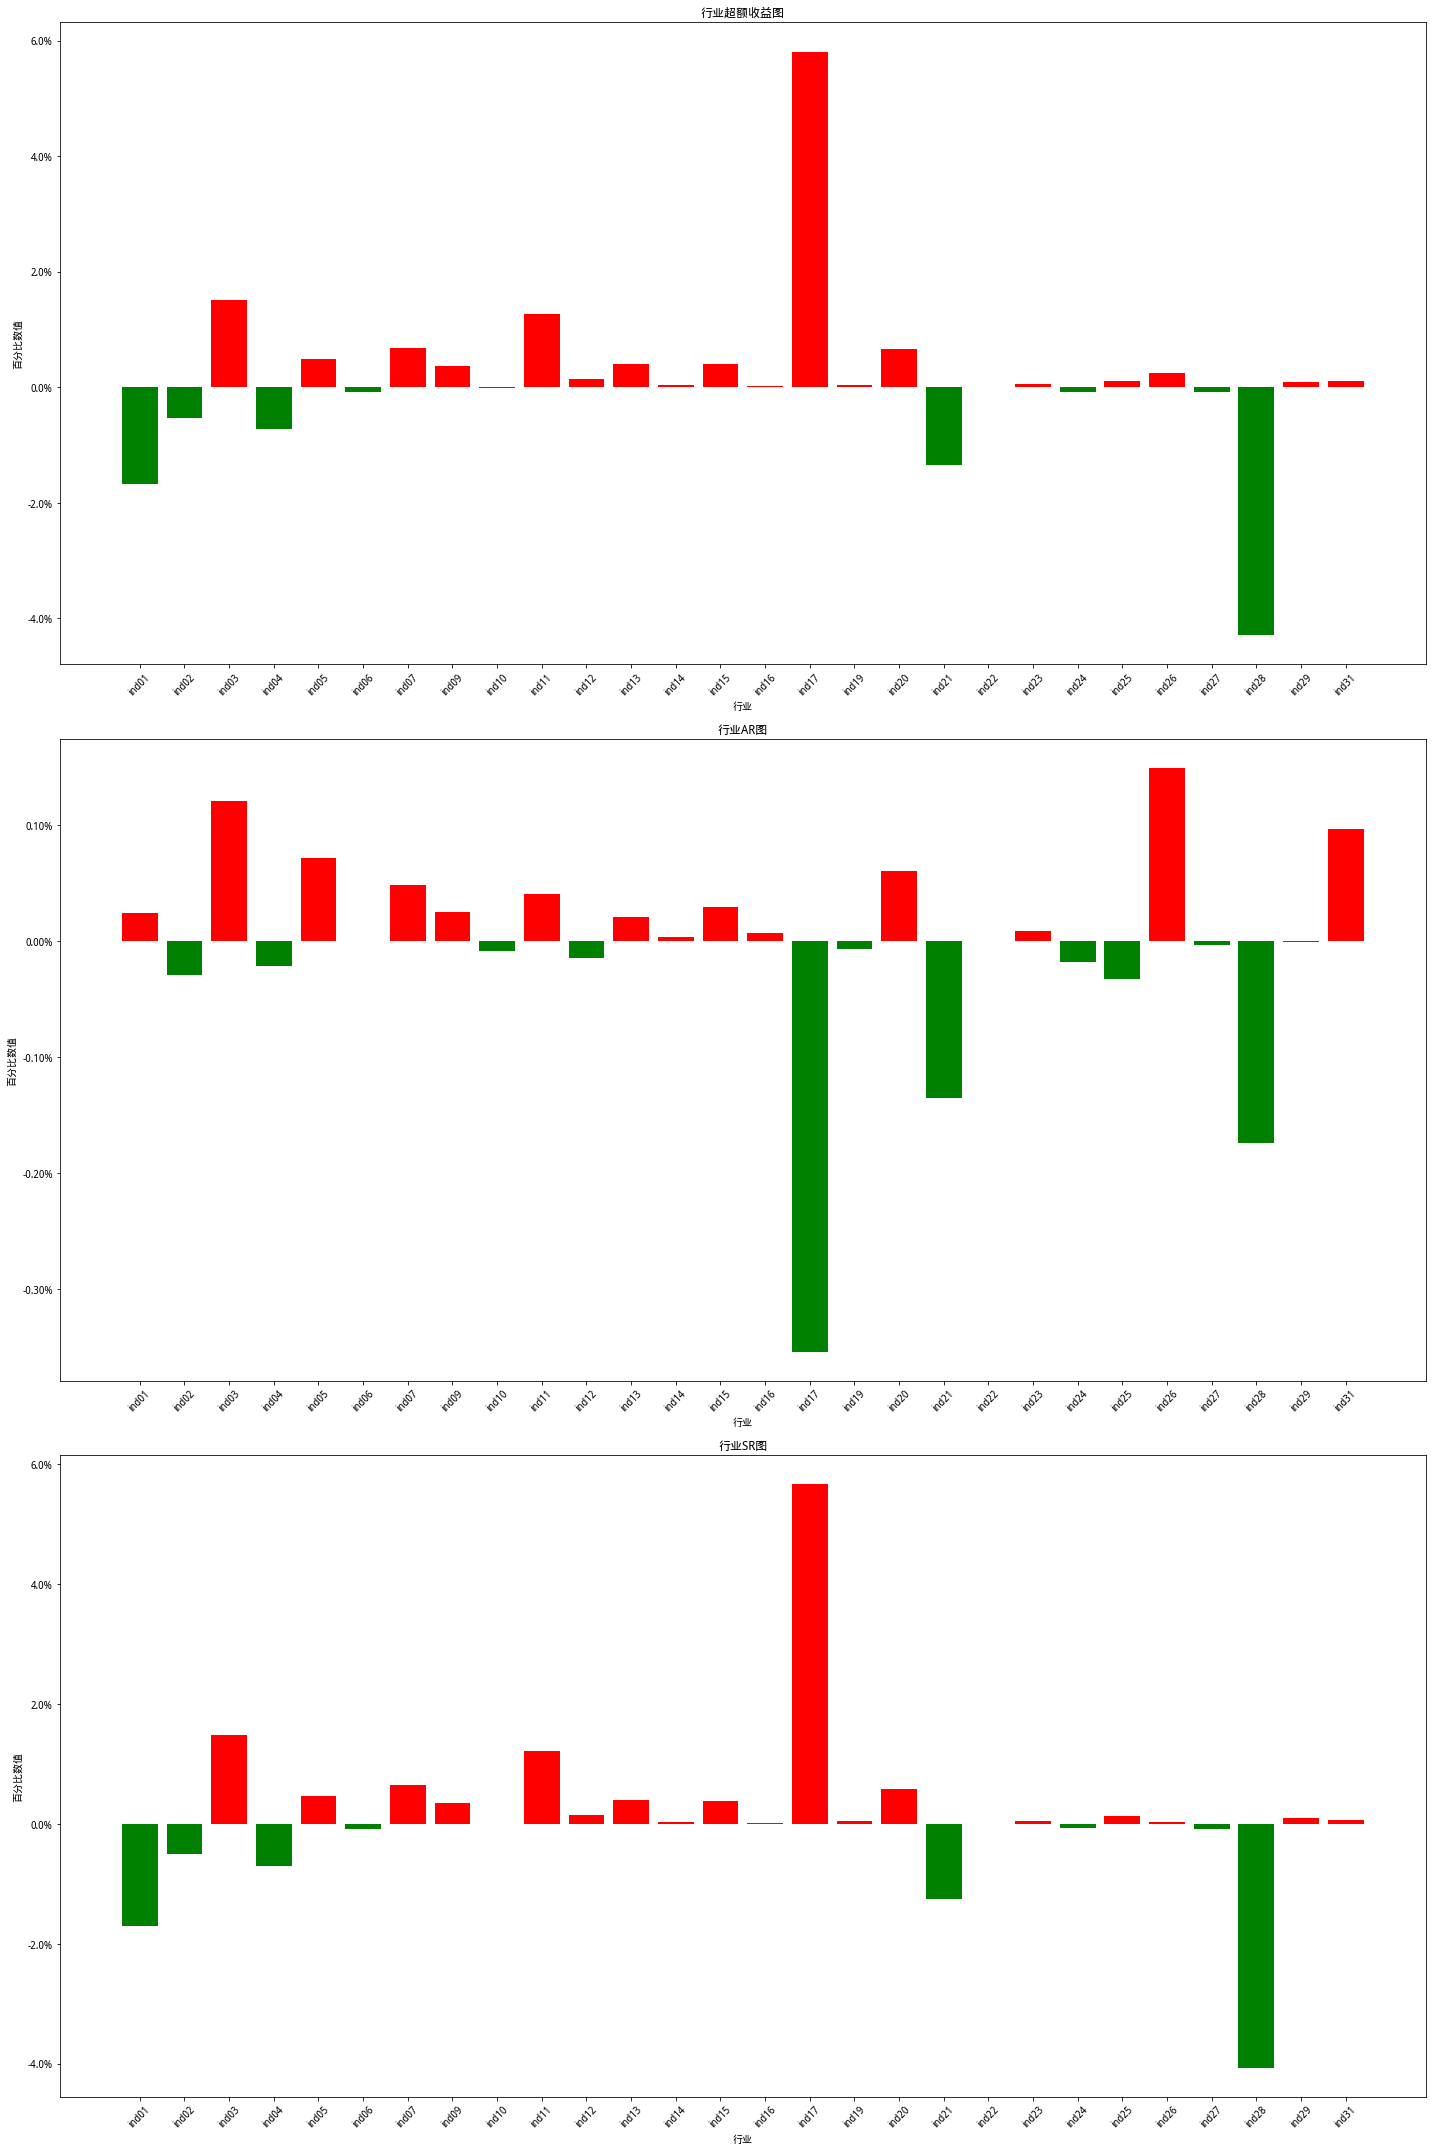

In [41]:
fig = plt.figure(figsize=(20,30))
ax=fig.add_subplot(311)
colors = ["green" if value < 0 else "red" for value in bhb_industry["R^A"]]
ax.bar(bhb_industry.index, bhb_industry["R^A"], color = colors)
ax.set(title="行业超额收益图", xlabel='行业', ylabel='百分比数值')
ax.set_xticklabels(bhb_industry.index,rotation=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax=fig.add_subplot(312)
colors = ["green" if value < 0 else "red" for value in bhb_industry["AR"]]
ax.bar(bhb_industry.index, bhb_industry["AR"], color = colors)
ax.set(title="行业AR图", xlabel='行业', ylabel='百分比数值')
ax.set_xticklabels(bhb_industry.index,rotation=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax=fig.add_subplot(313)
colors = ["green" if value < 0 else "red" for value in bhb_industry["SR"]]
ax.bar(bhb_industry.index, bhb_industry["SR"], color = colors)
ax.set(title="行业SR图", xlabel='行业', ylabel='百分比数值')
ax.set_xticklabels(bhb_industry.index,rotation=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
fig.tight_layout()